# Tips data analysis by Classification tools

Goal: find a customer who gives big tips

- Logistic regression
- QDA/LDA
- random forest
- Naive Bayes
- Decision Tree
- model combining 
    - voting, bagging, random forest

# Result:
### cross validation
with Logistic regression
>- accuracy: 0.8114795918367346
- recall: 0.73
- roc_auc: 0.8516864528728544
- f1: 0.3505860805860806

with naive
> - accuracy:  0.819672131147541
- recall:  0.7777777777777778
- roc_auc:  0.8003933136676499
- f1:  0.3888888888888889

In [1]:
from sklearn.metrics import *
from sklearn.model_selection import *

%matplotlib inline
tips=sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


In [2]:
tips['sex'] = tips['sex'].apply(lambda x: 1 if x == 'Male' else 0).astype('float64')
tips['smoker'] = tips['smoker'].apply(lambda x: 1 if x == 'Yes' else 0).astype('float64')
tips['time'] = tips['time'].apply(lambda x: 1 if x == 'Dinner' else 0).astype('float64')
tips['day'] = tips['day'].apply(lambda x: 0 if x == 'Thur' else 1 if x =='Fri' else 2 if x=='Sat' else 3).astype('float64')

In [3]:
tips.describe()

,total_bill,tip,sex,smoker,day,time,size
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,19.785943,2.998279,0.643443,0.381148,1.725410,0.721311,2.569672
std,8.902412,1.383638,0.479967,0.486667,1.155774,0.449276,0.951100
min,3.070000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.347500,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,17.795000,2.900000,1.000000,0.000000,2.000000,1.000000,2.000000
75%,24.127500,3.562500,1.000000,1.000000,3.000000,1.000000,3.000000
max,50.810000,10.000000,1.000000,1.000000,3.000000,1.000000,6.000000


In [4]:
# tips['upper3'] = tips['tip'].apply(lambda x: 1 if x >3 else 0)
tips['upper5'] = tips['tip'].apply(lambda x: 1 if x >5 else 0)
tips['target'] = tips['tip'].apply(lambda x: 'upper5' if x>5 else 'upper3' if x>3 else 'others')

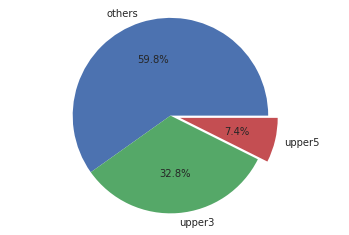

In [5]:
explode = (0, 0, 0.1)
plt.pie(tips.groupby('target')['tip'].count(), labels=['others', 'upper3', 'upper5'], 
       autopct='%1.1f%%' ,explode=explode)
plt.axis('equal')
plt.show()

upper5 - who gave more than 5 bucks

these people account for about 7 percent of customers.

In [6]:
X =tips[['total_bill', 'sex', 'smoker', 'day', 'time', 'size']]
y = tips['target']

---

# logistic

In [7]:
result = sm.Logit.from_formula(
    "upper5 ~ total_bill + sex + smoker + day + time + size", tips).fit(disp=0)

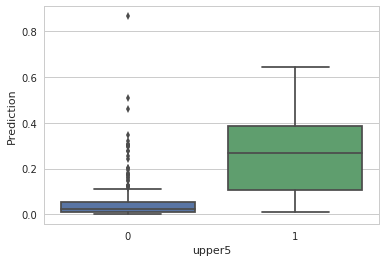

In [8]:
tips["Prediction"] = result.predict(tips)
sns.boxplot(x="upper5", y="Prediction", data=tips)
plt.show()

#### threshold on 10%
- higher recall score with little bit lower accuracy

10% 확률만 있어도 부자로 체크!
 - 부자를 찾아낼 확률이 올라간다! 물론 False Positive도 오른다.

In [9]:
y5 = tips['upper5']
y_pred = result.predict(X).apply(lambda x: 1 if x >=0.5 else 0)
print("50% \naccuracy score", accuracy_score(y5, y_pred),)
print("recall score", recall_score(y5, y_pred), "\n")

y_pred10 = result.predict(X).apply(lambda x: 1 if x >=0.1 else 0)
print("10% \naccuracy score", accuracy_score(y5, y_pred10),)
print("recall score", recall_score(y5, y_pred10), "\n")

target_names = ['others', 'upper5']
print("Confusion Matrix:\n\n",confusion_matrix(y5, y_pred10), "\n")
print("Classification report:\n\n",classification_report(y5, y_pred10, target_names=target_names))

50% 
accuracy score 0.930327868852459
recall score 0.16666666666666666 

10% 
accuracy score 0.8360655737704918
recall score 0.7777777777777778 

Confusion Matrix:

 [[190  36]
 [  4  14]] 

Classification report:

              precision    recall  f1-score   support

     others       0.98      0.84      0.90       226
     upper5       0.28      0.78      0.41        18

avg / total       0.93      0.84      0.87       244



#### if take 5%, recall score goes up 83%, but accuracy goes down to 74%
- time to choose

In [10]:
y_pred5 = result.predict(X).apply(lambda x: 1 if x >=0.05 else 0)
print("5% \naccuracy score", accuracy_score(y5, y_pred5),)
print("recall score", recall_score(y5, y_pred5), "\n")

print("Confusion Matrix:\n\n",confusion_matrix(y5, y_pred5), "\n")
print("Classification report:\n\n",classification_report(y5, y_pred5, target_names=target_names))

5% 
accuracy score 0.7459016393442623
recall score 0.8333333333333334 

Confusion Matrix:

 [[167  59]
 [  3  15]] 

Classification report:

              precision    recall  f1-score   support

     others       0.98      0.74      0.84       226
     upper5       0.20      0.83      0.33        18

avg / total       0.92      0.75      0.81       244



10% AUC : 0.8092428711897738
5% AUC : 0.7861356932153393


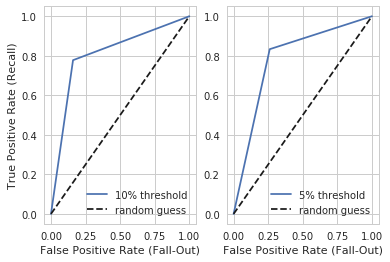

In [11]:
fpr5, tpr5, thresholds5 = roc_curve(y5, y_pred10)

plt.subplot(121)
plt.plot(fpr5, tpr5, label="10% threshold")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend()
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
print ("10% AUC :",auc(fpr5, tpr5))

fpr5, tpr5, thresholds5 = roc_curve(y5, y_pred5)

plt.subplot(122)
plt.plot(fpr5, tpr5, label="5% threshold")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend()
plt.xlabel('False Positive Rate (Fall-Out)')
print ("5% AUC :",auc(fpr5, tpr5))
plt.show()

10%'s AUC is slightly greater and slope is steeper. go for it

#### cross validation with scikit

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight={0:.1, 1:.9}).fit(X, y5)
cv = KFold(5)

print("accuracy:",cross_val_score(model, X, y5, scoring="accuracy", cv=cv).mean())
print("recall:",cross_val_score(model, X, y5, scoring="recall", cv=cv).mean())
print("roc_auc:",cross_val_score(model, X, y5, scoring="roc_auc", cv=cv).mean())
print("f1:",cross_val_score(model, X, y5, scoring="f1", cv=cv).mean())

accuracy: 0.8114795918367346
recall: 0.73
roc_auc: 0.8516864528728544
f1: 0.3505860805860806


---

### QDA LDA

In [13]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y = tips['upper5']
y1 = lb.fit_transform(tips['upper5'])

In [14]:
from sklearn.discriminant_analysis import *
qda= QuadraticDiscriminantAnalysis().fit(X, y)
lda = LinearDiscriminantAnalysis(n_components=3, solver="svd").fit(X, y)
lda_eigen = LinearDiscriminantAnalysis(n_components=3, solver="eigen", shrinkage='auto').fit(X, y)
y_pred1 = qda.predict(X)
y_pred2 = lda.predict(X)
y_pred3 = lda_eigen.predict(X)
target_names = ['others','upper5']

print("QDA \naccuracy score", accuracy_score(y1, y_pred1),)
print("recall score", recall_score(y1, y_pred1))

print("\nLDA_svd \naccuracy score", accuracy_score(y1, y_pred2),)
print("recall score", recall_score(y1, y_pred2), "\n")

print("\nLDA_eigen \naccuracy score", accuracy_score(y1, y_pred3),)
print("recall score", recall_score(y1, y_pred3), "\n")
print("confusion_matrix \n\n",confusion_matrix(y, y_pred3),"\n")
print(classification_report(y, y_pred2, target_names=target_names))


QDA 
accuracy score 0.9262295081967213
recall score 0.3333333333333333

LDA_svd 
accuracy score 0.930327868852459
recall score 0.2777777777777778 


LDA_eigen 
accuracy score 0.8934426229508197
recall score 0.6111111111111112 

confusion_matrix 

 [[207  19]
 [  7  11]] 

             precision    recall  f1-score   support

     others       0.94      0.98      0.96       226
     upper5       0.56      0.28      0.37        18

avg / total       0.92      0.93      0.92       244



QDA_AUC : 0.6533923303834808
LDA_svd_AUC : 0.6300393313667649
LDA_eigen_AUC : 0.7635201573254671


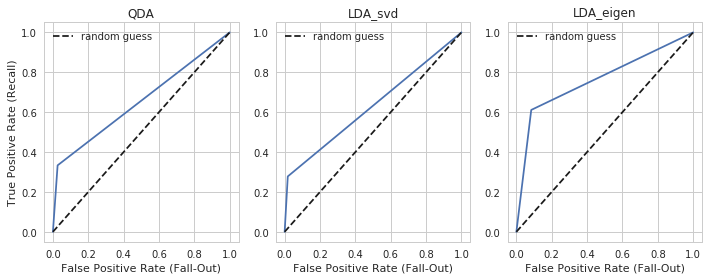

In [15]:
fpr5, tpr5, thresholds5 = roc_curve(y, y_pred1)

plt.figure(figsize=(10, 4))

plt.subplot(1,3,1)
plt.plot(fpr5, tpr5)
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend()
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('QDA')
print ("QDA_AUC :",auc(fpr5, tpr5))

fpr5, tpr5, thresholds5 = roc_curve(y, y_pred2)
plt.subplot(1,3,2)
plt.plot(fpr5, tpr5)
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend()
plt.xlabel('False Positive Rate (Fall-Out)')
plt.title('LDA_svd')
print ("LDA_svd_AUC :",auc(fpr5, tpr5))

fpr5, tpr5, thresholds5 = roc_curve(y, y_pred3)
plt.subplot(1,3,3)
plt.plot(fpr5, tpr5)
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend()
plt.xlabel('False Positive Rate (Fall-Out)')
plt.title('LDA_eigen')
print ("LDA_eigen_AUC :",auc(fpr5, tpr5))

plt.tight_layout()
plt.show()

LDA(svd solver) < QDA < LDA(eigen solver) < **Logistic**

---

In [16]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y = tips['target']
y1 = lb.fit_transform(tips['target'])

In [17]:
from sklearn.discriminant_analysis import *
qda = QuadraticDiscriminantAnalysis().fit(X, y)
lda = LinearDiscriminantAnalysis(n_components=3, solver="eigen", shrinkage='auto').fit(X, y)

y_pred = qda.predict(X)
y_pred2 = lda.predict(X)

print("QDA confusion_matrix \n\n",confusion_matrix(y, y_pred),"\n\n")
print("LDA confusion_matrix \n\n",confusion_matrix(y, y_pred2),"\n\n")

target_names = ['others', 'upper3','upper5']
print("QDA",classification_report(y, y_pred, target_names=target_names))
print("LDA",classification_report(y, y_pred2, target_names=target_names))


QDA confusion_matrix 

 [[126  19   1]
 [ 44  33   3]
 [  3   9   6]] 


LDA confusion_matrix 

 [[120  20   6]
 [ 37  29  14]
 [  3   4  11]] 


QDA              precision    recall  f1-score   support

     others       0.73      0.86      0.79       146
     upper3       0.54      0.41      0.47        80
     upper5       0.60      0.33      0.43        18

avg / total       0.66      0.68      0.66       244

LDA              precision    recall  f1-score   support

     others       0.75      0.82      0.78       146
     upper3       0.55      0.36      0.44        80
     upper5       0.35      0.61      0.45        18

avg / total       0.65      0.66      0.65       244



In [18]:
from sklearn.multiclass import OneVsRestClassifier
model1 = OneVsRestClassifier(QuadraticDiscriminantAnalysis()).fit(X, y)
model2 = OneVsRestClassifier(LinearDiscriminantAnalysis(n_components=3, solver="eigen", shrinkage='auto')).fit(X, y)

auc: 0.8066116857701984
auc: 0.7458079268292683
auc: 0.9164208456243854


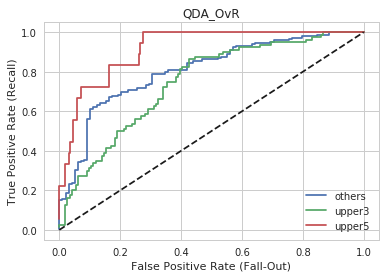

In [19]:
fpr1, tpr1, thresholds1 =roc_curve(y1[:,0], model1.decision_function(X)[:,0])
fpr2, tpr2, thresholds2 =roc_curve(y1[:,1], model1.decision_function(X)[:,1])
fpr3, tpr3, thresholds3 =roc_curve(y1[:,2], model1.decision_function(X)[:,2])

plt.plot(fpr1, tpr1, label="others")
plt.plot(fpr2, tpr2, label="upper3")
plt.plot(fpr3, tpr3, label="upper5")

plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('QDA_OvR')
print ("auc:",auc(fpr1, tpr1))
print ("auc:",auc(fpr2, tpr2))
print ("auc:",auc(fpr3, tpr3))

plt.show()

auc: 0.8145792563600783
auc: 0.7253810975609756
auc: 0.8522615535889871


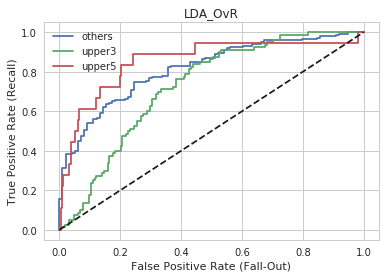

In [20]:
fpr1, tpr1, thresholds1 =roc_curve(y1[:,0], model2.decision_function(X)[:,0])
fpr2, tpr2, thresholds2 =roc_curve(y1[:,1], model2.decision_function(X)[:,1])
fpr3, tpr3, thresholds3 =roc_curve(y1[:,2], model2.decision_function(X)[:,2])

plt.plot(fpr1, tpr1, label="others")
plt.plot(fpr2, tpr2, label="upper3")
plt.plot(fpr3, tpr3, label="upper5")

plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('LDA_OvR')
print ("auc:",auc(fpr1, tpr1))
print ("auc:",auc(fpr2, tpr2))
print ("auc:",auc(fpr3, tpr3))

plt.show()

---

## Naive bayesian
- totalbill, - gaussan
- size, day - MNB
- sex, smoker, time -> Bin

In [21]:
y = tips['upper5']

/home/mk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


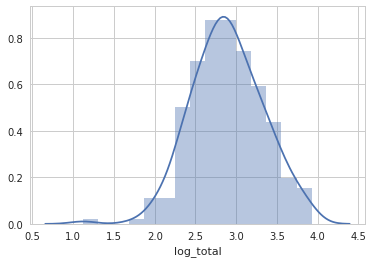

In [22]:
X['log_total'] = X['total_bill'].apply(lambda x: np.log(x))
sns.distplot(X['log_total'])
plt.show()

In [23]:
from sklearn.naive_bayes import *

log_total = X.iloc[:,-1:]
size_day = pd.concat([X.iloc[:, -2:-1], X.iloc[:, 3:4]], axis=1)
sex_smoker_time = X.iloc[:,2:5]

model_g = GaussianNB().fit(log_total, y)
model_bern = BernoulliNB().fit(sex_smoker_time, y)
model_mult = MultinomialNB().fit(size_day, y)

In [24]:
g = model_g.predict_proba(log_total)/model_g.class_prior_
bern = np.exp(model_bern.predict_log_proba(sex_smoker_time))/model_g.class_prior_
mult = np.exp(model_mult.predict_log_proba(size_day))/model_g.class_prior_

posterior = g*bern*mult*model_g.class_prior_

In [25]:
def zip_naive(posterior):
    result = []
    for a, b in posterior:
        if a>0.89: result.append(0)
        else: result.append(1)
    a = pd.Series(result)
    return a

In [26]:
y_pred = zip_naive(posterior)

print("accuracy: ", accuracy_score(y, y_pred))
print("recall: ", recall_score(y, y_pred))
print("roc_auc: ", roc_auc_score(y, y_pred))
print("f1: ", f1_score(y, y_pred))

accuracy:  0.819672131147541
recall:  0.7777777777777778
roc_auc:  0.8003933136676499
f1:  0.3888888888888889


### similar with logistic 

----

## Decision Tree

In [27]:
y = tips['upper5']
X = X.iloc[:, 1:]

In [28]:
from sklearn.tree import DecisionTreeClassifier
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

def draw_decision_tree(model):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=X.columns)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

In [29]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0).fit(X, y)
y_pred = tree.predict(X)

print(confusion_matrix(y, y_pred))
print("accuracy: ", accuracy_score(y, y_pred))
print("recall: ", recall_score(y, y_pred))
print("roc_auc: ", roc_auc_score(y, y_pred))
print("f1: ", f1_score(y, y_pred))

[[218   8]
 [  3  15]]
accuracy:  0.9549180327868853
recall:  0.8333333333333334
roc_auc:  0.8989675516224189
f1:  0.7317073170731708


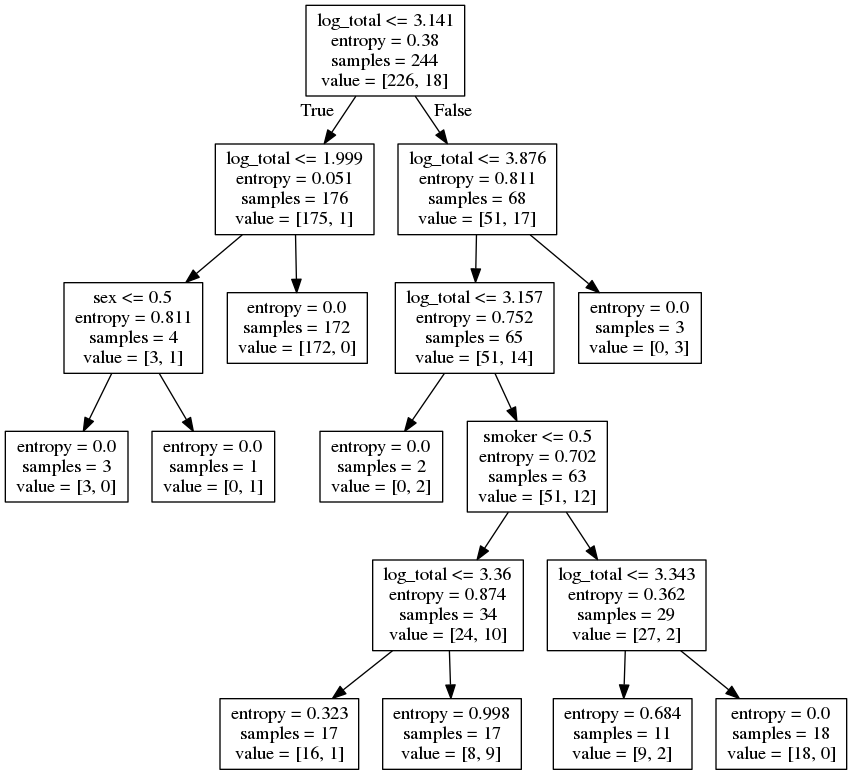

In [30]:
draw_decision_tree(tree)

In [31]:
print("accuracy:",cross_val_score(tree, X, y, scoring="accuracy", cv=cv).mean())
print("recall:",cross_val_score(tree, X, y, scoring="recall", cv=cv).mean())
print("roc_auc:",cross_val_score(tree, X, y, scoring="roc_auc", cv=cv).mean())
print("f1:",cross_val_score(tree, X, y, scoring="f1", cv=cv).mean())

accuracy: 0.9262755102040817
recall: 0.3
roc_auc: 0.797095282146161
f1: 0.2742857142857143


/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**overfitted.**

---

## Model combining

## 다수결

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(class_weight={0:.1, 1:.9}, random_state=1)
model2 = LinearDiscriminantAnalysis(n_components=3, solver="eigen", shrinkage='auto').fit(X, y)
model3 = GaussianNB()
ensemble = VotingClassifier(estimators=[('lr', model1), ('lda', model2), ('gnb', model3)], 
                            voting='soft', weights=[1, 1, 1])

In [33]:
ensem = ensemble.fit(X, y)

In [34]:
print("accuracy:",cross_val_score(ensem, X, y5, scoring="accuracy", cv=cv).mean())
print("recall:",cross_val_score(ensem, X, y5, scoring="recall", cv=cv).mean())

/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.9138605442176869
recall: 0.39


/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Return

## 배깅

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier


model1 = DecisionTreeClassifier().fit(X, y)
model2 = BaggingClassifier(DecisionTreeClassifier(), bootstrap_features=True, random_state=0).fit(X, y)

y_pred = model1.predict(X)
print("accuracy: ", accuracy_score(y, y_pred))
print("recall: ", recall_score(y, y_pred), "- Overfitting")
y_pred = model2.predict(X)
print("accuracy: ", accuracy_score(y, y_pred))
print("recall: ", recall_score(y, y_pred))

accuracy:  1.0
recall:  1.0 - Overfitting
accuracy:  0.9795081967213115
recall:  0.8333333333333334


In [36]:
print("accuracy:",cross_val_score(model1, X, y, scoring="accuracy", cv=cv).mean())
print("recall:",cross_val_score(model1, X, y, scoring="recall", cv=cv).mean())

accuracy: 0.914030612244898
recall: 0.36666666666666664


In [37]:
print("accuracy:",cross_val_score(model2, X, y, scoring="accuracy", cv=cv).mean())
print("recall:",cross_val_score(model2, X, y, scoring="recall", cv=cv).mean())

accuracy: 0.9139455782312925
recall: 0.18


## 랜덤 포레스트 

In [38]:
from sklearn.ensemble import *

DT = DecisionTreeClassifier(max_depth=4).fit(X, y)
forest = RandomForestClassifier(max_depth=4, n_estimators=250).fit(X, y)
Eforest = ExtraTreesClassifier(max_depth=4, n_estimators=250).fit(X, y)

print("DT: ",accuracy_score(y, DT.predict(X)))
print("recall: ", recall_score(y, DT.predict(X)))

print("\nF: ",accuracy_score(y, forest.predict(X)))
print("recall: ", recall_score(y, forest.predict(X)))

print("\nEF: ",accuracy_score(y,Eforest.predict(X)))
print("recall: ", recall_score(y, Eforest.predict(X)))

DT:  0.9713114754098361
recall:  0.7222222222222222

F:  0.9467213114754098
recall:  0.2777777777777778

EF:  0.9262295081967213
recall:  0.0


In [39]:
D = DT.feature_importances_
F = forest.feature_importances_
EF = Eforest.feature_importances_
print(tips.columns[:-4])
print('\n D:', D)
print('\n F:', F)
print('\n EF:', EF)

Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time'], dtype='object')

 D: [0.06428065 0.17355776 0.01213691 0.         0.11570517 0.63431952]

 F: [0.03131577 0.07840017 0.05550253 0.01317959 0.21431685 0.60728509]

 EF: [0.05666433 0.07612169 0.06605454 0.02518057 0.3207048  0.45527406]


Feature ranking:
1. feature 5 (0.607285)
2. feature 4 (0.214317)
3. feature 1 (0.078400)
4. feature 2 (0.055503)
5. feature 0 (0.031316)
6. feature 3 (0.013180)


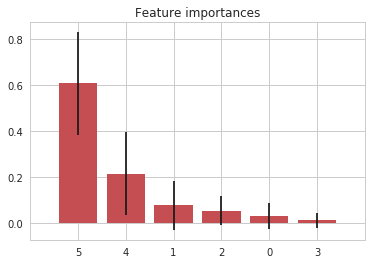

In [40]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(F)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], F[indices[f]]))

plt.title("Feature importances")
plt.bar(range(X.shape[1]), F[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [41]:
print("accuracy:",cross_val_score(DT, X, y5, scoring="accuracy", cv=cv).mean())
print("recall:",cross_val_score(DT, X, y5, scoring="recall", cv=cv).mean())

accuracy: 0.922108843537415
recall: 0.05


In [42]:
print("accuracy:",cross_val_score(forest, X, y5, scoring="accuracy", cv=cv).mean())
print("recall:",cross_val_score(forest, X, y5, scoring="recall", cv=cv).mean())

accuracy: 0.9221938775510203
recall: 0.1


In [43]:
print("accuracy:",cross_val_score(Eforest, X, y5, scoring="accuracy", cv=cv).mean())
print("recall:",cross_val_score(Eforest, X, y5, scoring="recall", cv=cv).mean())

accuracy: 0.922108843537415
recall: 0.0
